### GOAL:
THe goal of this project is to classify digits by finding statistical features like mean, variance and then using Bayesian posterior probabilities to arrive at a decision. 

In [62]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = scipy.io.loadmat('./data/train_data.mat')
test_data = scipy.io.loadmat('./data/test_data.mat')

In [66]:
images = train_data['data']
train_label = train_data['label'][0]

test_images = test_data['data']
test_label = test_data['label'][0]

#### Plot and image and compare its true label

In [64]:
print("The first image is ", train_label[0])

The first image is  3


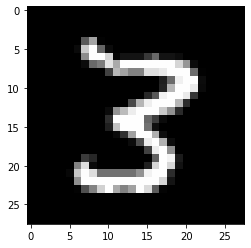

In [65]:
plt.imshow(images[0], cmap='gray')

###  1. Data Transformation
Each image is a 28X28 matrix containing hand written digits. We have to follow two steps to extract features of an image. 

Step 1: Feature extraction
Each image is stored as a 28x28 array of pixels. For each image i, compute two features: the mean mi and the standard deviation si of the 784 pixels
so each image i is now [mi, si] which are two features of the image

Step 2: Normalize the features

Using training dataset, for every feature calculated in previous step, we find M1, S1 which are mean and standard deviation for first feature. Similarly we calculate M2, S2. 

For every image i, 
Yi = [y1i, y2i] = [(mi – M1)/S1, (si – M2)/S2]t


#### Step 1: Feature extraction

In [8]:
X = np.zeros(shape = (len(images), 2))
print("train X is ", X.shape)
for index, image in enumerate(images):
    image_mean = image.mean()
    image_std = image.std()
    Xi = np.array([image_mean, image_std])
    X[index] = Xi

train X is  (11548, 2)


In [9]:
test_X = np.zeros(shape = (len(test_images), 2))
print("test_X is ", test_X.shape)

# take all test images and compress them into their mean and std
for index, image in enumerate(test_images):
    image_mean = image.mean()
    image_std = image.std()
    Xi = np.array([image_mean, image_std])
    test_X[index] = Xi

test_X is  (2886, 2)


#### Step 2: Feature normalization

In [11]:
[M1, M2] = X.mean(axis=0)
M1, M2

(32.504351071481686, 76.44042397326838)

In [12]:
[S1, S2] = X.std(axis = 0)
S1, S2

(9.349449452973955, 10.509725393032221)

In [13]:
#normalize X which is train features
X_normalize = np.zeros(shape = (len(images), 2))

for index, Xi in enumerate(X):
    x1 = (Xi[0] - M1)/S1
    x2 = (Xi[1] - M2)/S2
    X_normalize_i = np.array([x1, x2])
    X_normalize[index] = X_normalize_i

In [15]:
# normalize test images using M1, S1 and M2, S2 calculated using training data

X_test_normalize = np.zeros(shape = (len(test_images), 2))

for index, Xi in enumerate(test_X):
    x1 = (Xi[0] - M1)/S1
    x2 = (Xi[1] - M2)/S2
    X_test_normalize_i = np.array([x1, x2])
    X_test_normalize[index] = X_test_normalize_i

###  2. Density estimation

We assume that the 2-d feature space of X_normalize defined above, samples from each class follow a normal distribution. Using the maximum likelihood estimation method, we estimate the parameters for the 2-d normal distribution for each class/digit, using the respective training data for that class/digit.

A normal distribution is defined by 2 parameters - mean and variance. We need to calculate co-variance matrix if number of features >=2. 

In [16]:
X_normalize = X_normalize.tolist()

In [17]:
X_digit3, X_digit7 = [], []

for X_i, digit in zip(X_normalize, train_label):
    
    if(digit == 3):
        X_digit3.append(X_i)
    else:
        X_digit7.append(X_i)
        


In [18]:
X_digit3 = np.array(X_digit3)
X_digit7 = np.array(X_digit7)

In [24]:
mean3, var3, cov3 = X_digit3.mean(axis=0), X_digit3.var(axis=0), np.cov(X_digit3[:, 0], X_digit3[:, 1])
print(f"Mean: {mean3}, Variance: {var3}, Co-variance: {cov3}")

Mean: [0.37687996 0.31851855], Variance: [1.0491056  0.96037982], Co-variance: [[1.04928927 0.98734647]
 [0.98734647 0.96054796]]


In [29]:
mean7, var7, cov7 = X_digit7.mean(axis=0), X_digit7.var(axis=0), np.cov(X_digit7[:, 0], X_digit7[:, 1])
print(f"Mean: {mean7}, Variance: {var7}, Co-variance: {cov7}")

Mean: [-0.36900004 -0.31185886], Variance: [0.67669136 0.842203  ], Co-variance: [[0.67680735 0.74448378]
 [0.74448378 0.84234736]]


### 3. Bayesian Decision Theory for optimal classification 
Now we know what are the distributions of features when image is digit 3 and digit 7. For any new image, we can calculate likelihood (using multivariate density equation) using parameters estimated on training data


In [45]:
X = np.array(X_normalize)
X = X.reshape((-1, 2, 1))

test_X = np.array(X_test_normalize)
test_X = test_X.reshape((-1, 2, 1))

In [31]:
x = X[0]
x

array([[0.15069489],
       [0.12996069]])

In [32]:
# Reshaping matrices and calculating values for the equation of multivariate density
mean3 = mean3.reshape((2,1))
cov_inverse3 = np.linalg.inv(cov3)
determinant3 = np.linalg.det(cov3)

In [33]:
mean7 = mean7.reshape((2,1))
cov_inverse7 = np.linalg.inv(cov7)
determinant7 = np.linalg.det(cov7)

In [35]:
# P(x/digit) - based on formula for multivariate normal distribution
def likelihood_prob(x, mean, cov_inverse, determinant):
    temp = np.matmul(((x - mean).T), cov_inverse)

    power = (-1/2) * np.matmul(temp, (x-mean))
    power = power[0][0]

    exp = np.exp(power)
    prob = exp/(2*3.142*np.sqrt(determinant))
    return prob

In [43]:
X_normalize = np.array(X_normalize)
X_normalize.shape

(11548, 2)

### 4.  Training and testing error. 

Let's assume priors of both digits 3 and 7 are equal. 
since priors of both digits are equal, probability of digit given an image just depends on likelihood (using bayes theorem). 

We compare the results with the true label and add the probabilty of the incorrect correct class as the error. Its different when compared to accuracy. 

For example, if the true label is digit 3. Let's say model A predicts P(digit=3/X) = 0.8 and model B predicts P(digit=3/X) = 0.6. Here model B will be penalized more even though we will classify the digit as 3 i.e the model with less confidence will be penalized more. 

#### Error on training data

In [50]:
train_error = []
p_3, p_7 = 0.5, 0.5

# for every image of training data 
for x, digit in zip(X, train_label):
    likelihood_3 = likelihood_prob(x, mean3, cov_inverse3, determinant3 )
    likelihood_7 = likelihood_prob(x, mean7, cov_inverse7, determinant7 )
    
    
    if(digit == 3):
        train_error.append((likelihood_7 * p_7))
    else:
        train_error.append((likelihood_3 * p_3))    

In [47]:
print("training error prob: ", sum(train_error)/len(train_error))

training error prob:  0.21295144830184592


#### Error on Testing data

In [49]:
test_error = []
p_3, p_7 = 0.5, 0.5

for x, digit in zip(test_X, test_label):
    likelihood_3 = likelihood_prob(x, mean3, cov_inverse3, determinant3 )
    likelihood_7 = likelihood_prob(x, mean7, cov_inverse7, determinant7 )
    
    if(digit == 3):
        test_error.append(likelihood_7 * p_7)
    else:
        test_error.append(likelihood_3 * p_3)
        
    
print(" Testing error prob: ", sum(test_error)/len(test_error))

 Testing error prob:  0.20582431069013368


### 5. Accuracy
The accuracy of model is basically the percentage of digits that the model classified right. In this case since priors of digits 3 and 7 are equal i.e P(digit=3) = P(digit=7). 
so if likelihood(3) > likelihood(7), we classify as 3 else 7. 

In [56]:
# Accuracy on training data
correctly_classified = 0
p_3, p_7 = 0.5, 0.5

# for every image of training data 
for x, digit in zip(X, train_label):
    likelihood_3 = likelihood_prob(x, mean3, cov_inverse3, determinant3 )
    likelihood_7 = likelihood_prob(x, mean7, cov_inverse7, determinant7 )
    
    
    if(likelihood_3 > likelihood_7 and digit ==3):
        correctly_classified += 1
    elif(digit == 7):
        correctly_classified += 1   

print("Training accuracy: ",correctly_classified/len(train_label))

Training accuracy:  0.7496536196744025


In [57]:
correctly_classified = 0
p_3, p_7 = 0.5, 0.5

for x, digit in zip(test_X, test_label):
    likelihood_3 = likelihood_prob(x, mean3, cov_inverse3, determinant3 )
    likelihood_7 = likelihood_prob(x, mean7, cov_inverse7, determinant7 )
    
    if(likelihood_3 > likelihood_7 and digit == 3):
        correctly_classified += 1
    elif(digit == 7):
        correctly_classified += 1
        
    
print(" Testing accuracy: ", correctly_classified/len(test_label))

 Testing accuracy:  0.762993762993763


#### As wee see, by just extracting two features out of an image, mean and standard deviation, I get a testing accuracy of 76% with almost equally balanced dataset.